### Lasso Logistic regression

In [1]:
# Imports
import os
import numpy as np
import pandas as pd

(5636, 36)
          acct_ref      cust_ref has_dependents    tenure_mo home_phone  \
count         5636          5636           5636  5636.000000       5636   
unique        5621          5636              2          NaN          2   
top     ACCT940714  CUST61880322             No          NaN        Yes   
freq             2             1           3957          NaN       5079   
mean           NaN           NaN            NaN    32.445174        NaN   
std            NaN           NaN            NaN    24.515986        NaN   
min            NaN           NaN            NaN     0.000000        NaN   
25%            NaN           NaN            NaN     9.000000        NaN   
50%            NaN           NaN            NaN    29.000000        NaN   
75%            NaN           NaN            NaN    55.000000        NaN   
max            NaN           NaN            NaN    72.000000        NaN   

       multi_line internet_plan add_on_security add_on_backup  \
count        5636      

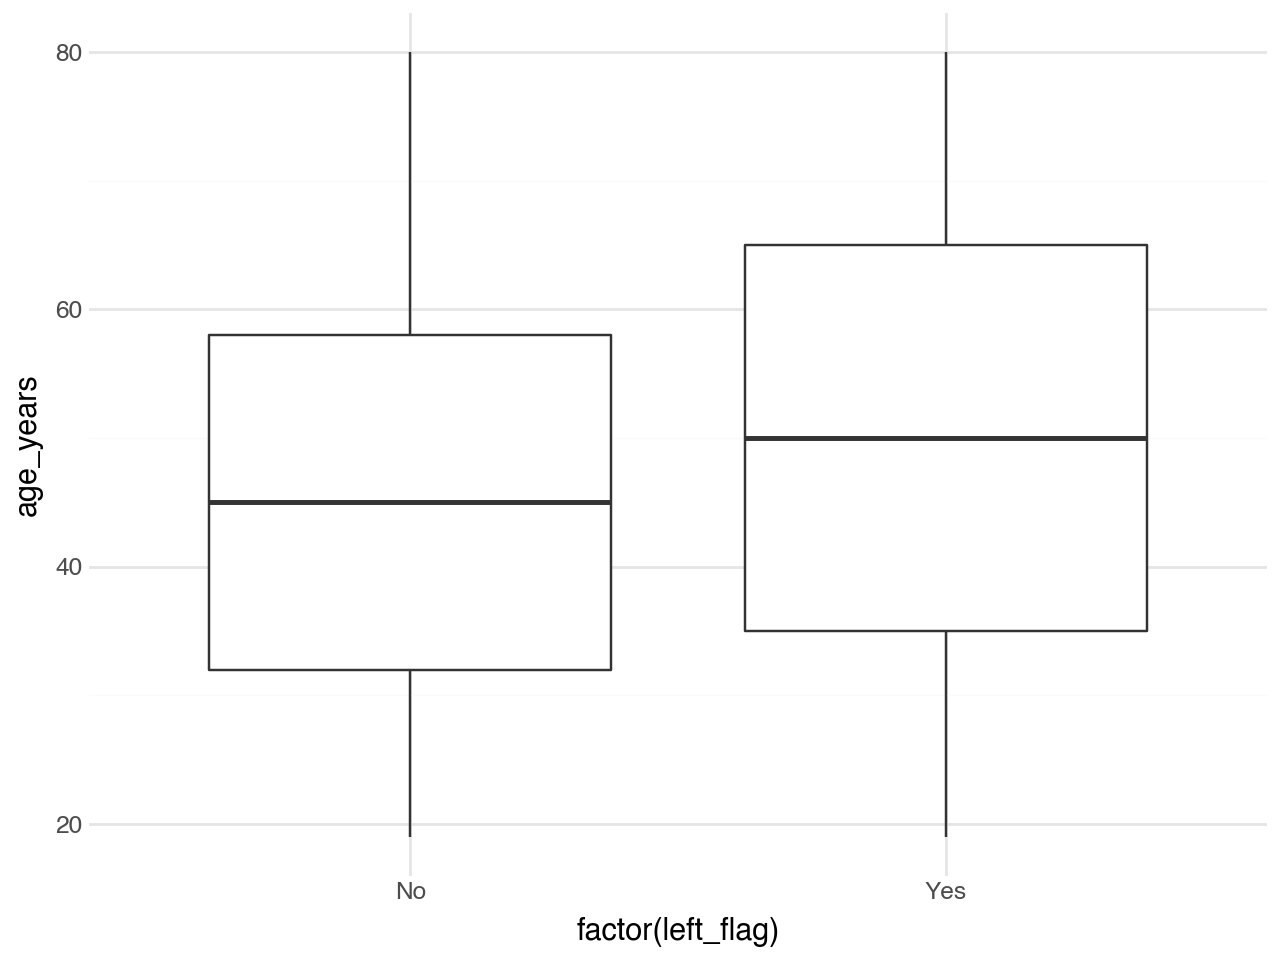

In [9]:
# Expect the file to be in the same folder as this notebook
df = pd.read_csv('retentiondata_case.csv' )
print(df.shape)
print(df.describe(include='all'))
print(df['left_flag'].value_counts())# summary stats

from plotnine import ggplot, aes, geom_boxplot, theme_minimal

p = (
    ggplot(df, aes(x='factor(left_flag)', y='age_years'))
    + geom_boxplot()
    + theme_minimal()
)
display(p)

In [12]:
### For classification problems, first determine the classes of your response variable
print(df["left_flag"].dtype)                     # what type is it? 
print(df["left_flag"].unique())                  # list of unique classes in the response variable

#df["left_flag"] = df["left_flag"].str.strip().str.lower().map({"yes": 1, "no": 0})

int64
[0 1]


In [13]:
# Then set the positive class to 1, so we predict probability of default (and not probability of notdefault)
pos_class = 1
Y = (df["left_flag"] == pos_class).astype(int)
X = pd.get_dummies(df.drop(columns=["left_flag"]), drop_first=True)  

In [14]:
from sklearn.model_selection import train_test_split, StratifiedKFold

#Split into train/test sets
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, 
    test_size=0.3,     # 30% test, 70% train
    random_state=99,   # reproducibility
    shuffle=True       # shuffle before splitting
)

# Check shapes
X_train.shape, X_test.shape

((3945, 11302), (1691, 11302))

In [16]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import StratifiedKFold

# Identify columns
cat_cols = X_train.select_dtypes(include="object").columns
num_cols = X_train.select_dtypes(include=["int64", "float64"]).columns

# Preprocessing
preprocess = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler(with_mean=True))
    ]), num_cols),

    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ]), cat_cols)
])

# CV setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=20)
lambdas = np.linspace(0.001, 2.0, 20)

# Full pipeline
logit_lasso_pipe = Pipeline([
    ("preprocess", preprocess),
    ("model", LogisticRegressionCV(
        Cs=1/lambdas,
        cv=cv,
        penalty="l1",
        solver="saga",
        scoring="roc_auc",
        max_iter=2000,
        n_jobs=-1,
        refit=True
    ))
])

# Fit
logit_lasso_pipe.fit(X_train, Y_train)

best_C = logit_lasso_pipe.named_steps["model"].C_[0]
best_lambda = 1.0 / best_C

print(f"Best C selected by CV: {best_C:.6g}   (λ = 1/C ≈ {best_lambda:.6g})")


Best C selected by CV: 0.527763   (λ = 1/C ≈ 1.89479)


In [19]:
preprocess = logit_lasso_pipe.named_steps["preprocess"]

# Get names for numeric features
num_features = preprocess.named_transformers_["num"].named_steps["scaler"].get_feature_names_out()

# Get names for categorical features
cat_features = preprocess.named_transformers_["cat"].named_steps["onehot"].get_feature_names_out()

# Combine them
all_features = np.concatenate([num_features, cat_features])


# Get coefficients from the fitted LASSO model it automatically chooses the best C(1/λ)
lasso_model = logit_lasso_pipe.named_steps["model"]

# Match each coefficient with its feature name
coef_df = pd.DataFrame({
    "feature": all_features,
    "coefficient": lasso_model.coef_.ravel()   # .coef_ is shape (1, n_features) for binary;
                                               # ravel() flattens it into a 1-D array
})

# Keep only non-zero coefficients (the ones LASSO thinks are important)
important_coefs = coef_df[coef_df["coefficient"] != 0]

# Sort by absolute size of the coefficient -- the larger the more important
important_coefs = important_coefs.reindex(
    important_coefs["coefficient"].abs().sort_values(ascending=False).index
)

print("Important features selected by LASSO:")
display(important_coefs)

NotFittedError: This OneHotEncoder instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.